In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

# Read the dataset
df = pd.read_csv("Data_set.csv")

# Select relevant columns
dff = df[['Date', 'MaxT', 'MinT', 'RH1', 'RH2', 'Wind', 'Rain', 'Evap', 'Radiation', 'Lat', 'Lon', 'Cum_Rain']]

# Fix specific data point
dff.loc[14410, 'Radiation'] = 8

# Check for null values
print("Null values in each column:\n", dff.isnull().sum())

# Drop rows with any null values (if any)
dff = dff.dropna()

# Split the data into features and labels
X = dff.drop('Date', axis=1)
y = dff['Date']  # Assuming 'Date' is just for splitting, not used as target

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)np
X_train = X[:12000]
X_test = X[12001:]
y_train = y[:12000]
y_test = y[12001:]

# Scale the features
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Time Series Generator for training
n_input = 7
n_para = X_train_norm.shape[1]  # Should be 11 based on the columns provided
train_generator = TimeseriesGenerator(X_train_norm, X_train_norm, length=n_input, batch_size=1)





C:\Users\Hp\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Null values in each column:
 Date         0
MaxT         0
MinT         0
RH1          0
RH2          0
Wind         0
Rain         0
Evap         0
Radiation    0
Lat          0
Lon          0
Cum_Rain     0
dtype: int64


In [4]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_para)))
model.add(Dense(30, activation='relu'))
model.add(Dense(n_para))  # Output all 11 parameters
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_generator, epochs=10, verbose=2)


C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11993/11993 - 83s - 7ms/step - loss: 0.0065
Epoch 2/10
11993/11993 - 82s - 7ms/step - loss: 0.0051
Epoch 3/10
11993/11993 - 72s - 6ms/step - loss: 0.0049
Epoch 4/10
11993/11993 - 68s - 6ms/step - loss: 0.0048
Epoch 5/10
11993/11993 - 65s - 5ms/step - loss: 0.0047
Epoch 6/10
11993/11993 - 62s - 5ms/step - loss: 0.0047
Epoch 7/10
11993/11993 - 62s - 5ms/step - loss: 0.0046
Epoch 8/10
11993/11993 - 62s - 5ms/step - loss: 0.0046
Epoch 9/10
11993/11993 - 63s - 5ms/step - loss: 0.0046
Epoch 10/10
11993/11993 - 62s - 5ms/step - loss: 0.0045


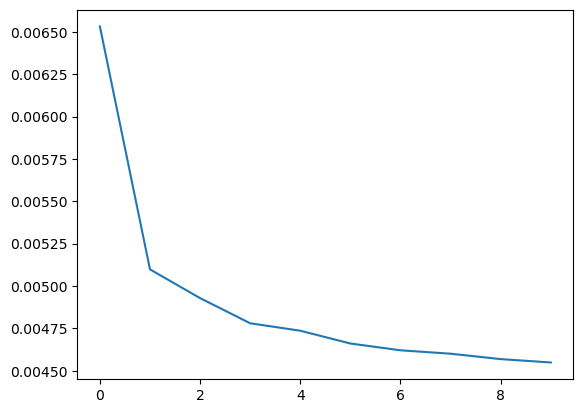

In [5]:
h = model.history.history['loss']
plt.plot(range(len(h)), h)
model.save('drought_prediction_model.keras')

  43/2845 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step

C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2845/2845 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Test Predictions Shape: (2845, 11)
y_Test Shape: (2852,)
Inverse Transformed Test Predictions:
 [[  29.163567   17.865084   94.62577  ...   17.508589   78.27267
  1038.4792  ]
 [  28.59638    20.384296   94.10872  ...   17.508457   78.272606
   984.3611  ]
 [  26.74453    20.597208   94.31086  ...   17.50826    78.27252
   976.3529  ]
 ...
 [  28.386591   22.232124   92.94004  ...   17.508625   78.27272
  1252.4421  ]
 [  28.999224   21.92452    93.22663  ...   17.50863    78.27269
  1264.3724  ]
 [  30.092606   21.135622   89.26287  ...   17.50816    78.27242
  1284.6564  ]]


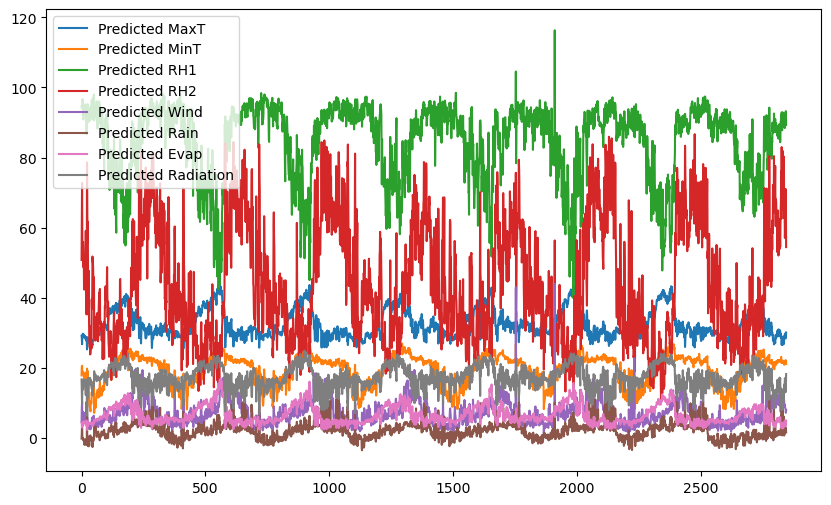

In [7]:
# Time Series Generator for testing
test_generator = TimeseriesGenerator(X_test_norm, X_test_norm, length=n_input, batch_size=1)

# Predict using the model on test data
test_predictions = model.predict(test_generator)

# Print predictions
print("Test Predictions Shape:", test_predictions.shape)
print("y_Test Shape:", y_test.shape)
#print("Test Predictions:\n", test_predictions)

# Optionally, you can inverse transform the predictions if you want to bring them back to the original scale
test_predictions_inv = scaler.inverse_transform(test_predictions)

# Print inverse transformed predictions
print("Inverse Transformed Test Predictions:\n", test_predictions_inv)

# Optionally, plot the predictions
plt.figure(figsize=(10, 6))
for i in range(n_para):
    plt.plot(test_predictions_inv[:, i], label=f'Predicted {dff.columns[i+1]}')
    if (i >= n_para - 4 or ):
        break
plt.legend()
plt.show()

In [2]:
inp = X_test.tail(7).to_numpy()
inp_norm = scaler.transform(inp)
serri = inp_norm.reshape(1,7,11)
predictions = []

predict = model.predict(serri)
pre_inv = scaler.inverse_transform(predict)
predictions.append(pre_inv)

for i in range(7):
    inp = inp[1:]
    inp = np.concatenate((inp, pre_inv))
    serri = scaler.transform(inp)
    predict = model.predict(serri.reshape(1,7,11))
    pre_inv = scaler.inverse_transform(predict)
    predictions.append(pre_inv)

for i in range(len(predictions)):
    print(predictions[i], '\n')


[[  30.2         23.          85.          60.          10.9
     0.           5.2         19.          17.5084095   78.2723004
  1488.7      ]
 [  30.2         23.          87.          61.          10.
     0.           4.3         18.3         17.5084095   78.2723004
  1488.7      ]
 [  29.5         22.2         93.          64.           9.6
     4.5          2.5         12.9         17.5084095   78.2723004
  1493.2      ]
 [  29.2         22.6         90.          70.           9.2
    13.2          4.7         11.7         17.5084095   78.2723004
  1506.4      ]
 [  29.6         22.4         91.          63.           7.6
    14.           3.6         15.          17.5084095   78.2723004
  1520.4      ]
 [  30.6         23.          87.          59.           8.2
     0.           5.2         19.7         17.5084095   78.2723004
  1520.4      ]
 [  30.6         23.          90.          62.           7.
     0.           4.9         18.          17.5084095   78.2723004
  1520.4  

"inp_norm = scaler.transform(inp)\nserri = inp_norm.reshape(1,7,11)\npredictions = []\n\npredict = model.predict(serri)\npre_inv = scaler.inverse_transform(predict)\npredictions.append(pre_inv)\n\nfor i in range(7):\n    inp = inp[1:]\n    inp = np.concatenate((inp, pre_inv))\n    serri = scaler.transform(inp)\n    predict = model.predict(serri.reshape(1,7,11))\n    pre_inv = scaler.inverse_transform(predict)\n    predictions.append(pre_inv)\n\nfor i in range(len(predictions)):\n    print(predictions[i], '\n')"

In [15]:
# Generate a daily date range for November 2023
start_date = pd.to_datetime('2023-11-01')
end_date = pd.to_datetime('2023-12-30')
date_range = pd.date_range(start_date, end_date, freq='D')

# Print the date range
print(len(date_range))
print(date_range)

60
DatetimeIndex(['2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04',
               '2023-11-05', '2023-11-06', '2023-11-07', '2023-11-08',
               '2023-11-09', '2023-11-10', '2023-11-11', '2023-11-12',
               '2023-11-13', '2023-11-14', '2023-11-15', '2023-11-16',
               '2023-11-17', '2023-11-18', '2023-11-19', '2023-11-20',
               '2023-11-21', '2023-11-22', '2023-11-23', '2023-11-24',
               '2023-11-25', '2023-11-26', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-02',
               '2023-12-03', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-09', '2023-12-10',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-16', '2023-12-17', '2023-12-18',
               '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22',
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
   

In [16]:
pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Hp\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip show keras

Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: C:\Users\Hp\anaconda3\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow-intel
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install keras.preprocessing

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorflow


In [3]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [2]:
from graphviz import Digraph


ModuleNotFoundError: No module named 'graphviz'

In [4]:
pip install graphviz



  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB 236.4 kB/s eta 0:00:00


In [5]:
from graphviz import Digraph

In [ ]:
# Time Series Generator for testing
test_generator = TimeseriesGenerator(X_test_norm, X_test_norm, length=n_input, batch_size=1)

# Predict using the model on test data
test_predictions = model.predict(test_generator)

# Print predictions
print("Test Predictions Shape:", test_predictions.shape)
print("y_Test Shape:", y_test.shape)
#print("Test Predictions:\n", test_predictions)

# Optionally, you can inverse transform the predictions if you want to bring them back to the original scale
test_predictions_inv = scaler.inverse_transform(test_predictions)

# Print inverse transformed predictions
print("Inverse Transformed Test Predictions:\n", test_predictions_inv)

# Optionally, plot the predictions
plt.figure(figsize=(10, 6))
for i in range(n_para):
    plt.plot(test_predictions_inv[:, i], label=f'Predicted {dff.columns[i+1]}')
plt.legend()
plt.show()
inp = X_test.tail(7).to_numpy()
inp_norm = scaler.transform(inp)
serri = inp_norm.reshape(1,7,11)
predictions = []

predict = model.predict(serri)
pre_inv = scaler.inverse_transform(predict)
predictions.append(pre_inv)

for i in range(7):
    inp = inp[1:]
    inp = np.concatenate((inp, pre_inv))
    serri = scaler.transform(inp)
    predict = model.predict(serri.reshape(1,7,11))
    pre_inv = scaler.inverse_transform(predict)
    predictions.append(pre_inv)

for i in range(len(predictions)):
    print(predictions[i], '\n')